# Step 1 Pre-Process Data

In [83]:
import numpy as np
from pathlib import Path
from skimage.io import imread
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2
import imgaug.augmenters as iaa
import h5py


from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [2]:
# This is not in the repo because it is too big.
# Download it from the kaggle site and keep it in the repo.
data_dir = Path('sacm2021')

train = data_dir / 'TrainImages/TrainImages'
test = data_dir / 'TestImages/TestImages'


train_images = train.glob('*.png')
test_images = train.glob('*.png')


# Store a link to the image and the id together in a list
# Will turn into a dataframe later
# Image label is the numeric part of the image file name
# Will extract that using some ~~~string magic~~~
training_data_and_id = []

for img in train_images:
    
    image_id = (
        str(img).
        replace(str(train), '').
        replace('.png', '').
        replace('/','') 
    )
    
    image_id = int(image_id)
    
    training_data_and_id.append((img, image_id))
    

In [3]:
image_frame = pd.DataFrame(training_data_and_id, columns = ['img','id'])
labels = pd.read_csv('sacm2021/train.csv')

# Combine the labels and the image locations into a single frame
df = image_frame.merge(labels)

print(df.head())

                                        img   id  classification
0  sacm2021/TrainImages/TrainImages/348.png  348               0
1  sacm2021/TrainImages/TrainImages/412.png  412               0
2  sacm2021/TrainImages/TrainImages/374.png  374               1
3  sacm2021/TrainImages/TrainImages/360.png  360               2
4  sacm2021/TrainImages/TrainImages/406.png  406               2


In [4]:
# Fairly even but not completely even
df.classification.value_counts(normalize=True).round(2)

2    0.35
0    0.23
1    0.22
3    0.21
Name: classification, dtype: float64

(782, 1024, 3)
(996, 1024, 3)
(840, 1024, 3)
(851, 1024, 3)
(840, 1024, 3)
(886, 1024, 3)
(888, 1024, 3)
(1024, 925, 3)
(855, 1024, 3)
738


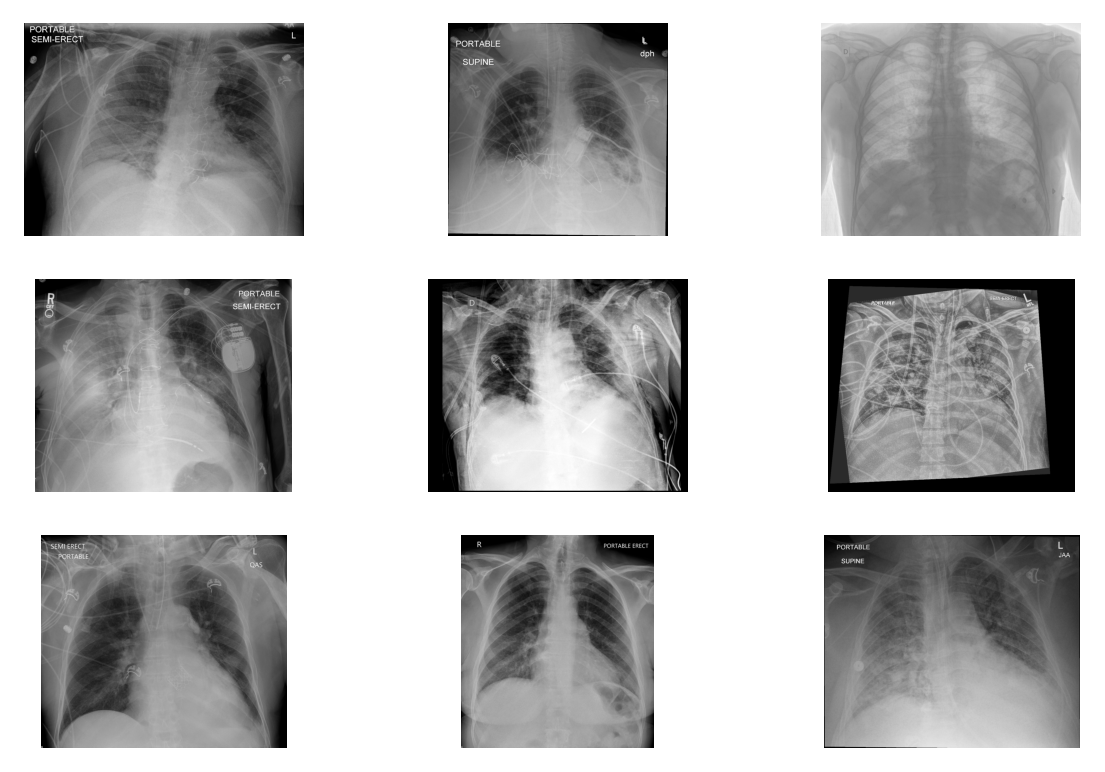

In [5]:
# What do a few of these look like?
fig, ax = plt.subplots(dpi = 240, nrows = 3, ncols = 3)
ax = ax.ravel()

xd = []

for img, axis in zip(df.sample(9).img.tolist(), ax):
    xray = imread(img)
    print(xray.shape)
    axis.imshow(xray)
    axis.axis('off')
    
# Figure out the minimum X dimension (*SLOW*, feel free to remove)
dims = [imread(str(df.iloc[i,0])).shape[0] for i in range(df.shape[0])]
#print(pd.Series(dims).value_counts())
print(np.min(dims))

In [35]:
# Prepare training and test sets 
train, validation = train_test_split(df, test_size=0.3, random_state=0)


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


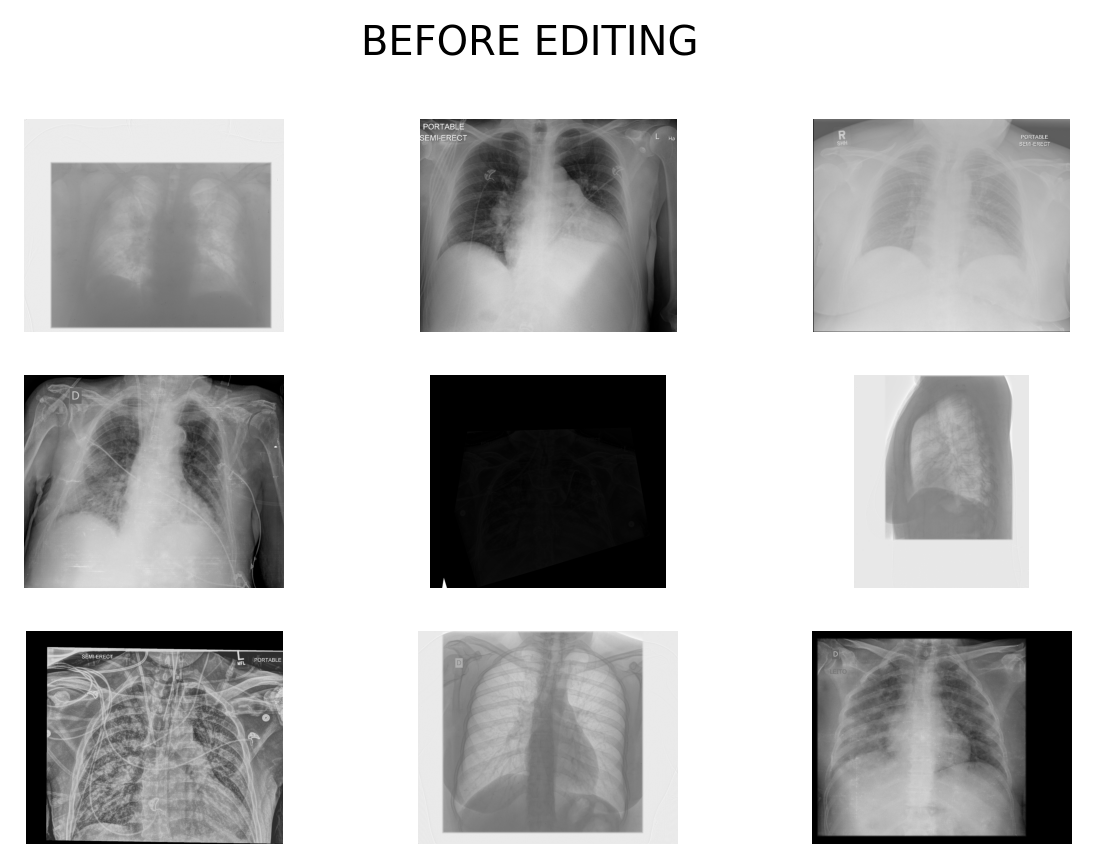

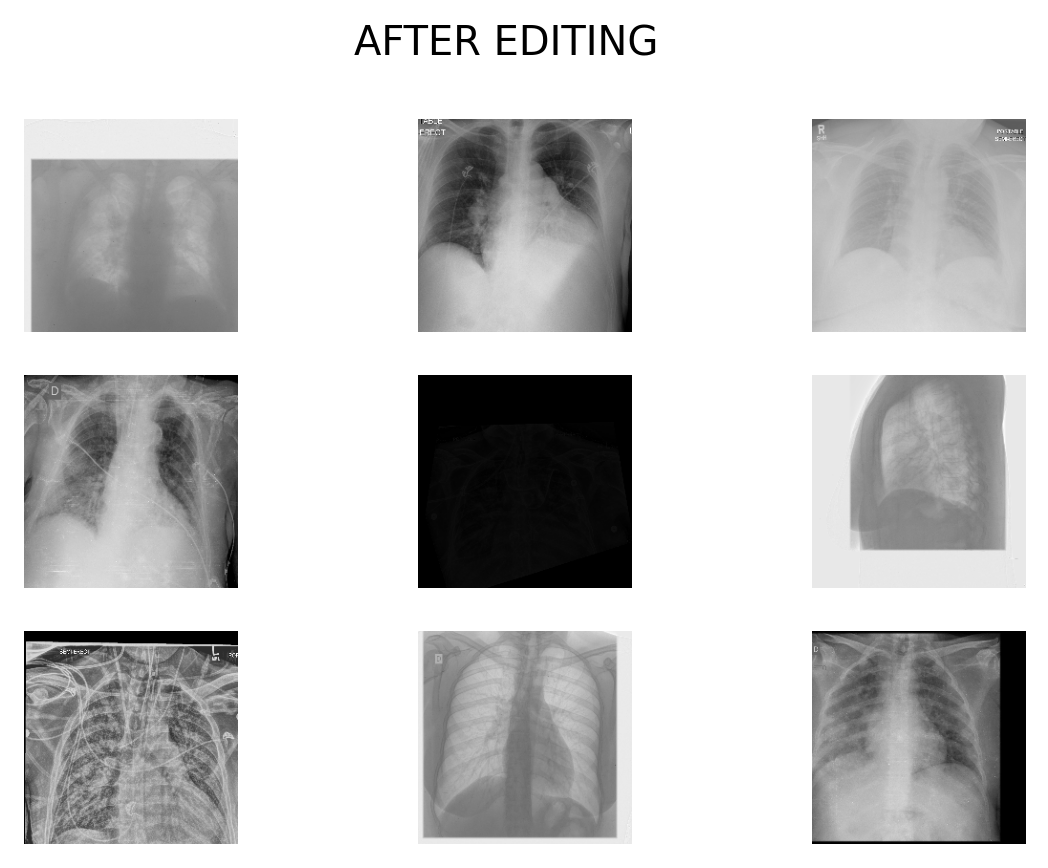

In [7]:
# Resizes the image to a square of size DIMxDIM
# Symmetrically crops x_trim % off the left/right ... same for y
def resizeCrop(img, square_dim=224, x_trim=0.075, y_trim=0.075):
    image = cv2.imread(str(img))
    
    # Trimming x and y based on size
    dim = image.shape
    
    x_scale = x_trim * ((dim[1] - 840)/ (1024-840)) # given dimensions,
    y_scale = y_trim * ((dim[0] - 738) / (1024-738)) # crop an appropriate amount (up to 10%)
    
    cut_y = int(np.round(dim[0]*y_scale))
    cut_x = int(np.round(dim[1]*x_scale))
    
    # Trim x and y 
    image = image[cut_y:dim[0]-cut_y,cut_x:dim[1]-cut_x]
    
    # Resize image 
    image = cv2.resize(image, (square_dim,square_dim))

    return(image)



# Plot before editing
fig, ax = plt.subplots(dpi = 240, nrows = 3, ncols = 3)
fig.suptitle('BEFORE EDITING')
ax = ax.ravel()

sample = train.iloc[:,0].sample(9)
print(type(sample))
for img, axis in zip(sample, ax):
    xray = imread(img)
    axis.imshow(xray)
    axis.axis('off')

sample = pd.Series([resizeCrop(x) for x in sample])
print(type(sample))  
# Plot after editing

fig, ax = plt.subplots(dpi = 240, nrows = 3, ncols = 3 )
fig.suptitle('AFTER EDITING')
ax = ax.ravel()

for img, axis in zip(sample, ax):
    #xray = imread(img)
    axis.imshow(img)
    axis.axis('off')  
    



In [8]:
# Preprocess the test/validation set 
test_img = []
test_lab = []

for i in range(test.shape[0]):
    test_img.append(resizeCrop(str(test.iloc[i,0])))
    test_lab.append(to_categorical(test.iloc[i,2], num_classes=4))
    
test_img = np.array(test_img)
test_lab = np.array(test_lab)

print(test_img.shape)
print(test_lab.shape)

(287, 224, 224, 3)
(287, 4)


In [51]:
def data_generator(img_paths, labels, batch_size):
    
    num_samples = len(img_paths)
    steps = num_samples//batch_size # // is equivalent to np.floor(x/y)
    
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype = np.float32)
    batch_labels = np.zeros((batch_size, 4), dtype = np.float32)
    
    indicies = np.arange(num_samples)
    
    i=0
    
    

    # Augmentation sequence 
    seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness


    while True:
        
        np.random.shuffle(indicies) # shuffles in place, no need to assign to a new variable
        
        count = 0
        
        next_batch = indicies[(i*batch_size):(i+1)*batch_size]
        
        for j, idx in enumerate(next_batch):
            
            img_name = img_paths[idx]
            label = labels[idx]
            
            encoded_label = to_categorical(label, num_classes=4)
            
            img = resizeCrop(img_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.0
            
            # Augment the image
            batch_data[count] = seq.augment_image(img)
            batch_labels[count] = encoded_label
            
        i+=1
        
        yield batch_data, batch_labels
        
        if i>steps:
            i = 0
            

In [52]:
# reshape the validation images

validation_labels = to_categorical(validation.classification.tolist())

validation_paths = [str(j) for j in validation.img.tolist()]

validation_data = np.zeros((len(validation_paths), 224, 224, 3))

for i, img_path in enumerate(validation_paths):
    
    image = cv2.imread(str(img_path))
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32)/255.
    validation_data[i] = image


In [69]:
train_labels = train.classification.tolist()

train_paths = [str(j) for j in train.img.tolist()]

In [70]:
dg = data_generator(train_paths, train_labels, 1)

next(dg)

(array([[[[0.5882353 , 0.5882353 , 0.5882353 ],
          [0.6039216 , 0.6039216 , 0.6039216 ],
          [0.5921569 , 0.5921569 , 0.5921569 ],
          ...,
          [0.6       , 0.6       , 0.6       ],
          [0.60784316, 0.60784316, 0.60784316],
          [0.6       , 0.6       , 0.6       ]],
 
         [[0.6117647 , 0.6117647 , 0.6117647 ],
          [0.6039216 , 0.6039216 , 0.6039216 ],
          [0.59607846, 0.59607846, 0.59607846],
          ...,
          [0.6       , 0.6       , 0.6       ],
          [0.6039216 , 0.6039216 , 0.6039216 ],
          [0.6       , 0.6       , 0.6       ]],
 
         [[0.6039216 , 0.6039216 , 0.6039216 ],
          [0.6039216 , 0.6039216 , 0.6039216 ],
          [0.6039216 , 0.6039216 , 0.6039216 ],
          ...,
          [0.59607846, 0.59607846, 0.59607846],
          [0.59607846, 0.59607846, 0.59607846],
          [0.6       , 0.6       , 0.6       ]],
 
         ...,
 
         [[0.38431373, 0.38431373, 0.38431373],
          [0.38039

# Step 2 Model Training

In [79]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(4, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

model =  build_model()

f = h5py.File('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()    


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [ ]:
opt = Adam(lr=0.01, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss=CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'],optimizer=opt)

In [ ]:
batch_size = 20
nb_epochs = 20

# Get a train data generator
data_generator(img_paths, labels, batch_size)
# Define the number of training steps
train_data_gen = data_generator(train_paths, train_labels, batch_size)

nb_train_steps = train.shape[0]//batch_size

In [87]:
# Fit the model
history = model.fit_generator(train_data_gen, 
                              epochs=nb_epochs, 
                              steps_per_epoch=nb_train_steps,
                              validation_data=(validation_data, validation_labels),
                              callbacks=[es, chkpt])




Epoch 1/20
33/33 [==============================] - 242s 7s/step - loss: 495.5229 - acc: 0.2561 - val_loss: 662.7168 - val_acc: 0.2265
Epoch 2/20
33/33 [==============================] - 237s 7s/step - loss: 1063.9166 - acc: 0.2621 - val_loss: 1623.1130 - val_acc: 0.2265
Epoch 3/20
33/33 [==============================] - 248s 8s/step - loss: 2228.1964 - acc: 0.2409 - val_loss: 3144.0358 - val_acc: 0.2265
Epoch 4/20
33/33 [==============================] - 220s 7s/step - loss: 3523.4369 - acc: 0.2455 - val_loss: 6102.9502 - val_acc: 0.2265
Epoch 5/20
33/33 [==============================] - 213s 6s/step - loss: 4289.7826 - acc: 0.2530 - val_loss: 10081.2869 - val_acc: 0.2265
Epoch 6/20
33/33 [==============================] - 210s 6s/step - loss: 6920.2637 - acc: 0.2636 - val_loss: 23201.7935 - val_acc: 0.2265


In [78]:
?Dropout